In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY is not set in the .env file.")
print("Gemini api key loaded successfully")

if not LANGSMITH_API_KEY:
    raise ValueError("LANGSMITH_API_KEY is not set in the .env file.")
print("LANGSMITH_API_KEY loaded successfully")

Gemini api key loaded successfully
LANGSMITH_API_KEY loaded successfully


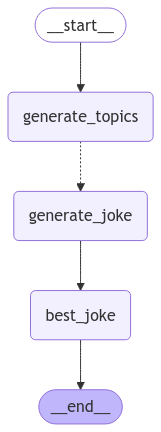

{'generate_topics': {'subjects': ['dog', 'cat', 'bird', 'fish', 'reptile']}}
{'generate_joke': {'jokes': ['Why are dogs such bad dancers? Because they have two left feet!']}}
{'generate_joke': {'jokes': ['Why do cats make terrible dancers? Because they have two left feet!']}}
{'generate_joke': {'jokes': ["Why don't birds play poker in the forest? Too many cheetahs!"]}}
{'generate_joke': {'jokes': ['Why did the snake cross the road? Because it was tired of slithering!']}}
{'generate_joke': {'jokes': ['Why did the fish blush? Because it saw the ocean floor.']}}
{'best_joke': {'best_selected_joke': 'Why are dogs such bad dancers? Because they have two left feet!'}}


In [2]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.types import Send
from langgraph.graph import END, StateGraph, START
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import display,Image

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",api_key=GEMINI_API_KEY  )
 
subjects_prompt = """Generate a comma separated list of between 2 and 5 examples related to: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""


class Subjects(BaseModel):
    subjects: list[str]


class Joke(BaseModel):
    joke: str


class BestJoke(BaseModel):
    id: int = Field(description="Index of the best joke, starting with 0", ge=0)

 
 
class OverallState(TypedDict):
    topic: str
    subjects: list  
    jokes: Annotated[list, operator.add]
    best_selected_joke: str
 
class JokeState(TypedDict):
    subject: str

 
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}
 
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


 
def continue_to_jokes(state: OverallState): 
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


 
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

 
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()
display(Image(app.get_graph(graph).draw_mermaid_png()))
for s in app.stream({"topic": "animals"}):
    print(s)

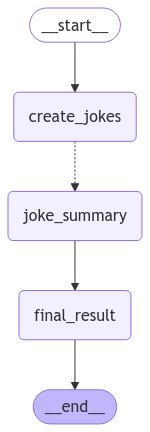

In [5]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.types import Send
from langgraph.graph import END, StateGraph, START
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import display,Image

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",api_key=GEMINI_API_KEY  )
from operator import add
from langgraph.graph import END, StateGraph, START

class JokesOutputSchema(BaseModel):
    jokes: list[str]
    
class GraphState(TypedDict):
    joke_topic:str
    jokes: list[str]
    jokesSummary: Annotated[list[str], add]
    finalResult:str
    currentJoke:str

class CurrentJokeState(TypedDict):
    currentJoke:str

create_joke_prompt = """
Genertate a list of jokes related to this topic: {joke_topic}""" 
   
def create_jokes(state:GraphState):
    joke_prompt = state['joke_topic']
    prompt = create_joke_prompt.format(joke_topic=joke_prompt)
    structured_output = llm.with_structured_output(JokesOutputSchema)
    output=structured_output.invoke(prompt)
    return {"jokes": output.jokes}


def jokeSummary(state:CurrentJokeState):
    current_joke = state["currentJoke"]
    return {'jokesSummary':[current_joke.replace(" ","_")]}

def final_result(state:GraphState):
    jokesSummary = state["jokesSummary"]
    finalResult =""
    for i, sum in enumerate(jokesSummary):
        resp=f"Joke {i}: "+sum+"\n\n"
        finalResult += resp 
    return {'finalResult':finalResult}

def continue_to_jokes_summary(state:GraphState):
    return [Send("joke_summary", {"currentJoke": joke}) for joke in state["jokes"]]

 
graph = StateGraph(GraphState)
graph.add_node('create_jokes',create_jokes)
graph.add_node('joke_summary',jokeSummary)
graph.add_node('final_result',final_result) 
graph.add_edge(START,'create_jokes')
graph.add_conditional_edges("create_jokes", continue_to_jokes_summary, ["joke_summary"])
graph.add_edge('joke_summary','final_result')
graph.add_edge('final_result',END)
final_graph = graph.compile()

display(Image(final_graph.get_graph().draw_mermaid_png()))
 

In [6]:
resp = final_graph.invoke({'joke_topic':'Elephan'})
print(resp)

{'joke_topic': 'Elephan', 'jokes': ['Why did the elephant cross the road? To get to the other side!', 'What do you call a lazy kangaroo? Pouch potato!', "What did the elephant say to the peanut? Nothing, elephants can't talk!"], 'jokesSummary': ['Why_did_the_elephant_cross_the_road?_To_get_to_the_other_side!', 'What_do_you_call_a_lazy_kangaroo?_Pouch_potato!', "What_did_the_elephant_say_to_the_peanut?_Nothing,_elephants_can't_talk!"], 'finalResult': "Joke 0: Why_did_the_elephant_cross_the_road?_To_get_to_the_other_side!\n\nJoke 1: What_do_you_call_a_lazy_kangaroo?_Pouch_potato!\n\nJoke 2: What_did_the_elephant_say_to_the_peanut?_Nothing,_elephants_can't_talk!\n\n"}


# Sub_Graph

In [ ]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.types import Send
from langgraph.graph import END, StateGraph, START
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import display, Image

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",api_key='API_KEY'  )
from operator import add  

class JokesOutputSchema(BaseModel):
    jokes: list[str]
    
class GraphState(TypedDict):
    joke_topic: str
    jokes: list[str]
    jokesSummary: Annotated[list[str], add]
    finalResult: str

class CurrentJokeState(TypedDict):
    currentJoke: str

create_joke_prompt = "Generate a list of jokes related to this topic: {joke_topic}" 
   
def create_jokes(state: GraphState):
    joke_prompt = state['joke_topic']
    prompt = create_joke_prompt.format(joke_topic=joke_prompt)
    structured_output = llm.with_structured_output(JokesOutputSchema)
    output = structured_output.invoke(prompt)
    return {"jokes": output.jokes}

def jokeSummary(state: CurrentJokeState):
    current_joke = state["currentJoke"]
    return {'jokesSummary': [current_joke.replace(" ", "_")]}

def jokeReverser(state: CurrentJokeState):
    current_joke = state["currentJoke"]
    print(f'jokeReverser:{current_joke}')
    return {'jokesSummary': [current_joke.replace("_", "__")]}

def final_result(state: GraphState):
    jokesSummary = state.get("jokesSummary", [])
    finalResult = "\n\n".join(f"Joke {i + 1}: {sum}" for i, sum in enumerate(jokesSummary))
    return {'finalResult': finalResult}
 
def continue_to_jokes_summary(state: GraphState):
    return [Send("sub_graph", {"currentJoke": joke}) for joke in state["jokes"]]
 
sub_graph = StateGraph(CurrentJokeState)  
sub_graph.add_node('joke_summary', jokeSummary)
sub_graph.add_node('joke_reverser', jokeReverser)

sub_graph.add_edge(START, 'joke_summary')
sub_graph.add_edge('joke_summary', 'joke_reverser')
sub_graph.add_edge('joke_reverser', END)

compiled_subgraph = sub_graph.compile()
 
graph = StateGraph(GraphState)
graph.add_node('create_jokes', create_jokes)
graph.add_node("sub_graph", compiled_subgraph)
graph.add_node('final_result', final_result) 

graph.add_edge(START, 'create_jokes')
graph.add_conditional_edges("create_jokes", continue_to_jokes_summary, ["sub_graph"])
graph.add_edge('sub_graph', 'final_result')
graph.add_edge('final_result', END)

final_graph = graph.compile()
display(Image(final_graph.get_graph().draw_mermaid_png()))
resp = final_graph.invoke({'joke_topic': 'Elephant'})
print(resp)


In [4]:
!pip install langgraph

ERROR: Could not find a version that satisfies the requirement langgraph (from versions: none)
ERROR: No matching distribution found for langgraph


In [2]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.types import Send
from langgraph.graph import END, StateGraph, START
from pydantic import BaseModel, Field 
from IPython.display import display, Image 
from operator import add  

class GraphState(TypedDict):  
    greeting:Annotated[list,add]

class CurrentState(TypedDict):
    current_greeting: str
 
greetings = [
    "hi","hello","holo"
   ] 
 
final_result =[]
def greet(state: CurrentState): 
    print(f'greeter fun calling {state["current_greeting"]}')  
    final_result.append(state["current_greeting"])
    print(f'final_result:{final_result}')
    return {"greeting": [state["current_greeting"]]}   
def start_greet(state: GraphState):
  pass
 
def decidenode(state: GraphState):
    return [Send("sub_graph", {"current_greeting": i}) for i in greetings ]
 
sub_graph = StateGraph(CurrentState)   
sub_graph.add_node("greet", greet)
sub_graph.add_edge(START, 'greet') 
sub_graph.add_edge('greet', END)

compiled_subgraph = sub_graph.compile()
graph = StateGraph(GraphState)
graph.add_node('start_greet', start_greet)
graph.add_node("sub_graph", compiled_subgraph) 

graph.add_edge(START, 'start_greet')
graph.add_conditional_edges("start_greet", decidenode, ["sub_graph"]) 
graph.add_edge('sub_graph', END)

final_graph = graph.compile()
display(Image(final_graph.get_graph().draw_mermaid_png()))  
# resp = final_graph.invoke({'greeting': []}) 
# print(resp)

ModuleNotFoundError: No module named 'langchain_core.tracers._streaming'

In [2]:
from typing import Any, TypeVar, Hashable

class Send:
    __slots__ = ("node", "arg")

    def __init__(self, node: str, arg: Any) -> None:
        self.node = node
        self.arg = arg

    def __hash__(self) -> int:
        return hash((self.node, self.arg))

    def __repr__(self) -> str:
        return f"Send(node={self.node!r}, arg={self.arg!r})"

    def __eq__(self, other: object) -> bool:
        return (
            isinstance(other, Send)
            and self.node == other.node
            and self.arg == other.arg
        )

N = TypeVar("N", bound=Hashable)

msg = [Send("generate_joke", {"subject": value}) for value in ['cats','birds','dogs']]


In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END 

class State(TypedDict):
  value:str

class ReturnedNodeValue:
  def __init__(self,value):
    self.value = value
  def __call__(self,state:State):
    print(f"Adding this value {state['value']}")
    return {"value": self.value}


builder = StateGraph(State)
builder.add_node('a',ReturnedNodeValue("A"))
builder.add_node('b',ReturnedNodeValue("B"))
builder.add_node('c',ReturnedNodeValue("C"))
builder.add_node('d',ReturnedNodeValue("D"))

builder.add_edge(START,'a')
builder.add_edge('c','d')
builder.add_edge('b','d')
builder.add_edge('a','c')
builder.add_edge('a','b')
builder.add_edge('d',END)
graph = builder.compile() 

In [9]:
from typing import TypedDict, Callable, Any, Dict, List, Optional, Tuple
# from IPython.display import display,Image
# 1) Define your state schema
from IPython.display import Image,display
class State(TypedDict):
    value: str

# 2) Wrap your node logic in callables
class ReturnedNodeValue:
    def __init__(self, value: str):
        self.value = value

    def __call__(self, state: State) -> Dict[str, Any]:
        # This replicates: print(f"Adding this value {state['value']}")
        print(f"Adding this value {state['value']}")
        # Return the update to the shared state
        return {"value": self.value}

# 3) A simple builder that collects nodes and edges
class GraphBuilder:
    def __init__(self):
        self.nodes: Dict[str, Callable[[State], Dict[str, Any]]] = {}
        self.edges: Dict[str, List[str]] = {}

    def add_node(self, name: str, fn: Callable[[State], Dict[str, Any]]):
        self.nodes[name] = fn

    def add_edge(self, src: str, dst: str):
        self.edges.setdefault(src, []).append(dst)

    def compile(self) -> "GraphExecutor":
        return GraphExecutor(self.nodes, self.edges)

# 4) The executor that “runs” the graph
class GraphExecutor:
    def __init__(
        self,
        nodes: Dict[str, Callable[[State], Dict[str, Any]]],
        edges: Dict[str, List[str]],
    ):
        self.nodes = nodes
        self.edges = edges

    def invoke(self, initial_state: State) -> State:
        # Start from the special START node
        queue: List[Tuple[str, State]] = [("START", initial_state)]
        final_state: Optional[State] = None

        while queue:
            node, state = queue.pop(0)
            # If we hit END, capture the state and continue
            if node == "END":
                final_state = state
                continue

            # 1) Run node logic (if any)
            if node in self.nodes:
                updates = self.nodes[node](state)
                # merge the update into the state
                # (later branches will  override earlier keys)
                new_state = {**state, **updates}  # shallow merge
            else:
                new_state = state

            # 2) Enqueue downstream nodes
            for downstream in self.edges.get(node, []):
                queue.append((downstream, new_state))

        # Return the last state that reached END
        return final_state or initial_state

# 5) Build exactly your original graph
builder = GraphBuilder()
builder.add_node("a", ReturnedNodeValue("A"))
builder.add_node("b", ReturnedNodeValue("B"))
builder.add_node("c", ReturnedNodeValue("C"))
builder.add_node("d", ReturnedNodeValue("D"))

builder.add_edge("START", "a")
# builder.add_edge("a", "c")
# builder.add_edge("a", "b")
# builder.add_edge("c", "d")
# builder.add_edge("b", "d")
builder.add_edge("a", "END")

graph = builder.compile()

# 6) Run it
final = graph.invoke({"value": "initial"})
print("Final state:", final) 

Adding this value initial
Final state: {'value': 'A'}
